# Office Items Multi-class classification  
This notebook explores **domain adaptation** for image classification of an office dataset using the method outlined in [this paper](https://arxiv.org/pdf/1711.02536.pdf).  

---

## Helper Functions
These next four functions are used throughout the notebook

---

### **Validation** Function

In [12]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("Index error")
        print("dataset length:",len(data_loader.dataset))
        steps = [validation_step for validation_step, batch in enumerate(data_loader)]
        print("final validation step:", steps[-1])

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        try:
            msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)
        except ZeroDivisionError:
            print("Zero division error")
            print(classerr.value())
            print(losses['objective_loss'])

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
   
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

### **Test** Function

In [13]:
def test(test_loader, model, model_path, loggers, conf, epoch=-1, tflogger=None):
    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
    msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)

### **Training** Function

In [3]:
def train(train_loader, val_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)
    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
    
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    msglogger.info('Training time: %s', datetime.now() - tic)

### **Embedding Visualization** Function

In [4]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,domain,to_pred=False):
    if domain == 0:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 1:
        _, _, test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_val = False, load_test=True)
        test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    elif domain == 2:
        _, _, source_test_set, _ = conf.dataset_fn((test_batch_path+"/source/", conf.args), load_train=False, load_val = False, load_test=True)
        source_test_loader = DataLoader(source_test_set, batch_size=batch_size, shuffle=True)
        _, _, target_test_set, _ = conf.dataset_fn((test_batch_path+"/target/", conf.args), load_train=False, load_val = False, load_test=True)
        target_test_loader = DataLoader(target_test_set, batch_size=batch_size, shuffle=True)

    

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    if domain == 0 or domain == 1:
        # get a batch of data
        (batch_imgs, batch_labels, batch_paths) = next(iter(test_loader))
        batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        preds = model(batch_imgs)
        embds = activation['fc1']

        # get the labels
        batch_label_strings = []
        for idx,label in enumerate(batch_labels):
            batch_label_strings.append(test_set.label_dict[label.item()])

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )
        
        if to_pred:
            print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))
    
    if domain == 2:

        # get a batch of data
        (source_batch_imgs, source_batch_labels, paths) = next(iter(source_test_loader))
        source_batch_imgs,source_batch_labels = source_batch_imgs.to(conf.device), source_batch_labels.to(conf.device)
        (target_batch_imgs, target_batch_labels, paths) = next(iter(target_test_loader))
        target_batch_imgs,target_batch_labels = target_batch_imgs.to(conf.device), target_batch_labels.to(conf.device)

        # register forward hook to get embedding output
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook

        # get the activations
        model.eval()
        model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
        source_preds = model(source_batch_imgs)
        source_embds = activation['fc1']
        target_preds = model(target_batch_imgs)
        target_embds = activation['fc1']

        # get the labels
        source_batch_label_strings = []
        for idx,label in enumerate(source_batch_labels):
            source_batch_label_strings.append(source_test_set.label_dict[label.item()]+"_SRC")

        target_batch_label_strings = []
        for idx,label in enumerate(target_batch_labels):
            target_batch_label_strings.append(target_test_set.label_dict[label.item()]+"_TGT")

        batch_imgs = torch.cat((source_batch_imgs,target_batch_imgs))
        batch_labels = torch.cat((source_batch_labels,target_batch_labels))
        source_batch_label_strings.extend(target_batch_label_strings)
        embds = torch.cat((source_embds,target_embds))

        print(source_batch_label_strings)

        # log to tensorboard
        tflogger.tblogger.writer.add_embedding(
                embds.to('cpu'),
                metadata=source_batch_label_strings,
                label_img=batch_imgs.to('cpu'),
                global_step=0
            )

---

## Quantization and Synthesis  

These cells are defined here at the top for conveniance  

---

### **Quantize** a model  
To execute this cell, change the virtual environment to ai8x-synthesis

In [1]:
%reload_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint.pth.tar jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint-q.pth.tar --device MAX78000 -v

Configuring device: MAX78000
Converting checkpoint file jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint.pth.tar to jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.conv3.bias_bits, feature_extractor.conv3.quant

### **Evaluate** a quantized model  
To execute these cell, change the virtual environment to ai8x-training

#### Import needed modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

#### Load the model from the desired checkpoint

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#load_model_path = 'jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar-q.pth.tar'
#load_model_path = "jupyter_logging/finetune_office5___2022.07.07-161909/classifierbackbonenet_qat_best-q.pth.tar"
#load_model_path = "jupyter_logging/dcd_train_adv___2022.07.13-143739/officeclassifier_qat_best-q.pth.tar"
#load_model_path = "jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best-q.pth.tar"
load_model_path = "jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint-q.pth.tar"

# Change this path to match file system layout
data_path = "../Datasets/office5_test_baseline/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.OfficeClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


#### Load the test data

In [3]:
args = Args(act_mode_8bit=True)

# choose which dataset helper function you want
__, _, test_dataset, _ = office5_get_datasets(("../Datasets/domain_adaptation/office5/target", args), load_train=False, load_val=False, load_test=True, validation_split=0, \
                                                           fix_aug=None, deterministic=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


#### Run a simple test loop

In [4]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label, path in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 87.30%


#### Before syntehsis, create a test image if needed

In [ ]:
# set the file name accordingly
for image, label in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_office.npy', im_sample)

#### Visualize the image
We can check the simulated result at the bottom of log.txt

In [ ]:
plt.imshow((image[0].detach().cpu().permute(1, 2, 0)+128)/255)
label[0]

### **Synthesize** a quantized model  
To execute these cell, change the virtual environment to ai8x-synthesis

In [2]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix office_DA_k8_new --checkpoint-file ../ai8x-training/jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

/home/geffencooper/Model_Development/ai8x-synthesis


WARNING:

Configuring device: MAX78000
Reading networks/classifier.yaml to configure network...
Reading ../ai8x-training/jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint-q.pth.tar to configure network weights...
Checkpoint for epoch 7, model officeclassifier_qat - weight and bias data:
 InCh OutCh  Weights         Quant Shift  Min  Max    Size Key                                       Bias       Quant  Min  Max Size Key
    3     8  (24, 3, 3)          8     0  -81   61     216 feature_extractor.conv1.op.weight         N/A            0    0    0    0 N/A                      
    8     8  (64, 3, 3)          8     0  -90   63     576 feature_extractor.conv2.op.weight         N/A            0    0    0    0 N/A                      
    8    16  (128, 3, 3)         8     0 -120   55    1152 feature_extractor.conv3.op.weight         N/A            0    0    0    0 N/A                      
   16    16  (256, 3, 3)         8     0  -69   44    

Cannot check for updates for git branch "DA" from GitHub - Branch not found


WARNING:

Layer 11: `flatten` is not needed since input dimensions are 1x1.


WARNING:

Layer 12: `flatten` is not needed since input dimensions are 1x1.


Output()

office_DA_k8_new...


Output()

Output()

## **Step 1**: Pre-train an encoder on 300K images from PASS using SimCLR method
---

### Import the necessary modules and define some helper functions

In [23]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

### Define Training Configurations (args)

In [24]:
class Config:
    def __init__(self):
        self.dataset_name = "pass"
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 512
        self.validation_split = 0.0
        self.log_prefix = "SSL"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/PASS_dataset/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':15, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()
conf.is_classification = False

### Set up the logger

In [25]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/SSL___2022.07.21-104809/SSL___2022.07.21-104809.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7f4f7dadf940>
num_classes=0
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 15, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



### Create and visualize the dataset
* Each sample is a pair of augmented images

../Datasets/PASS_dataset/train


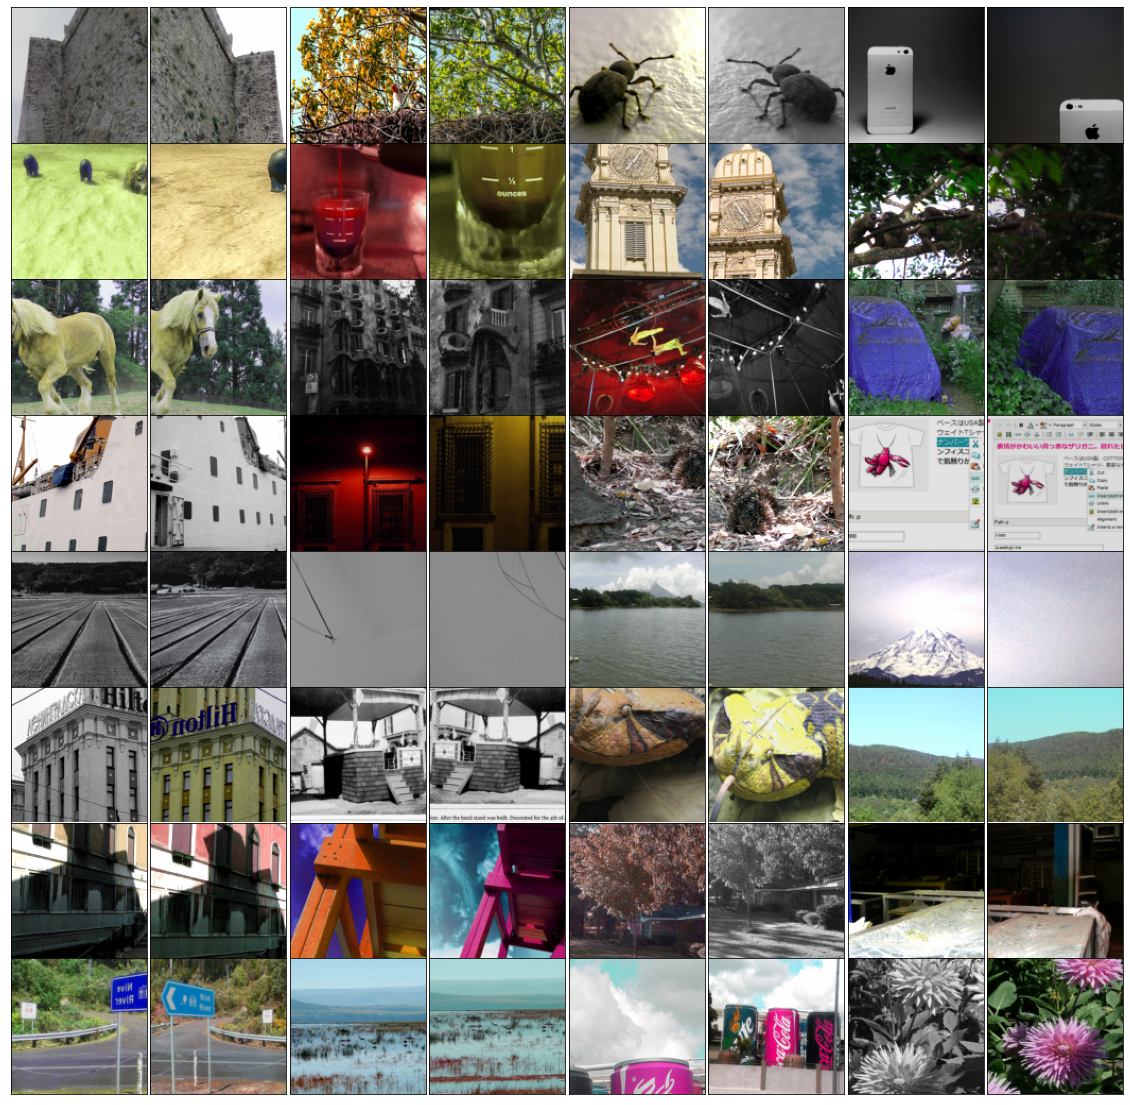

In [26]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

### Create the data loaders

In [27]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=299999
	validation=1
	test=1
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/PASS_dataset/train
../Datasets/PASS_dataset/test


### Set up the device, cuda or cpu

In [28]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


### Set up the model for training

In [29]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ClassifierBackbone()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: ClassifierBackbone(
  (conv1): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (conv2): FusedConv2dReLU(
    (activate): ReLU(inplace=True)
    (op): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (

Configuring device: MAX78000, simulate=False.


### Set up optimizer, loss, and learning schedule

In [30]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss

In [31]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[15, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({15: 1, 35: 1, 100: 1}) gamma: 0.5


### Define the forward function
* this generalizes the way we do a forward pass so we can reuse the training/validation functions for different models

In [33]:
def SSL_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = SSL_forward

### Train the model

In [ ]:
train(train_loader, val_loader, model,conf)

## **Step 2**: Fine-tune pre-trained encoder to office5 dataset  
* Use the validation accuracy over multiple runs (random validation set selected each time) to tune hyperparameters, augmentations, etc. 
* Only evaluate on the test set once you are finished tuning the model parameters. The results on the test set are the most meaningful this way.  

---

### 0.**Setup** Training

#### Import modules

In [5]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

#### Define new training parameters for classification

In [6]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "finetune_office5_SSL300k_base_ev4"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/domain_adaptation/office5/source/"
        self.deterministic = False
        self.aug_seed = 416679289
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop','mouse','pen')
        self.lr = 0.001
        self.num_epochs = 40
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

#### Set up the logger

In [7]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_office5_SSL300k_base_ev4___2022.07.21-115954/finetune_office5_SSL300k_base_ev4___2022.07.21-115954.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7fb2d2103ee0>
num_classes=5
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=40
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



#### Create the training, validation, and test datasets and dataloaders

../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


Dataset sizes:
	training=382
	validation=42
	test=48
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)
Augmentation Seed:416679289


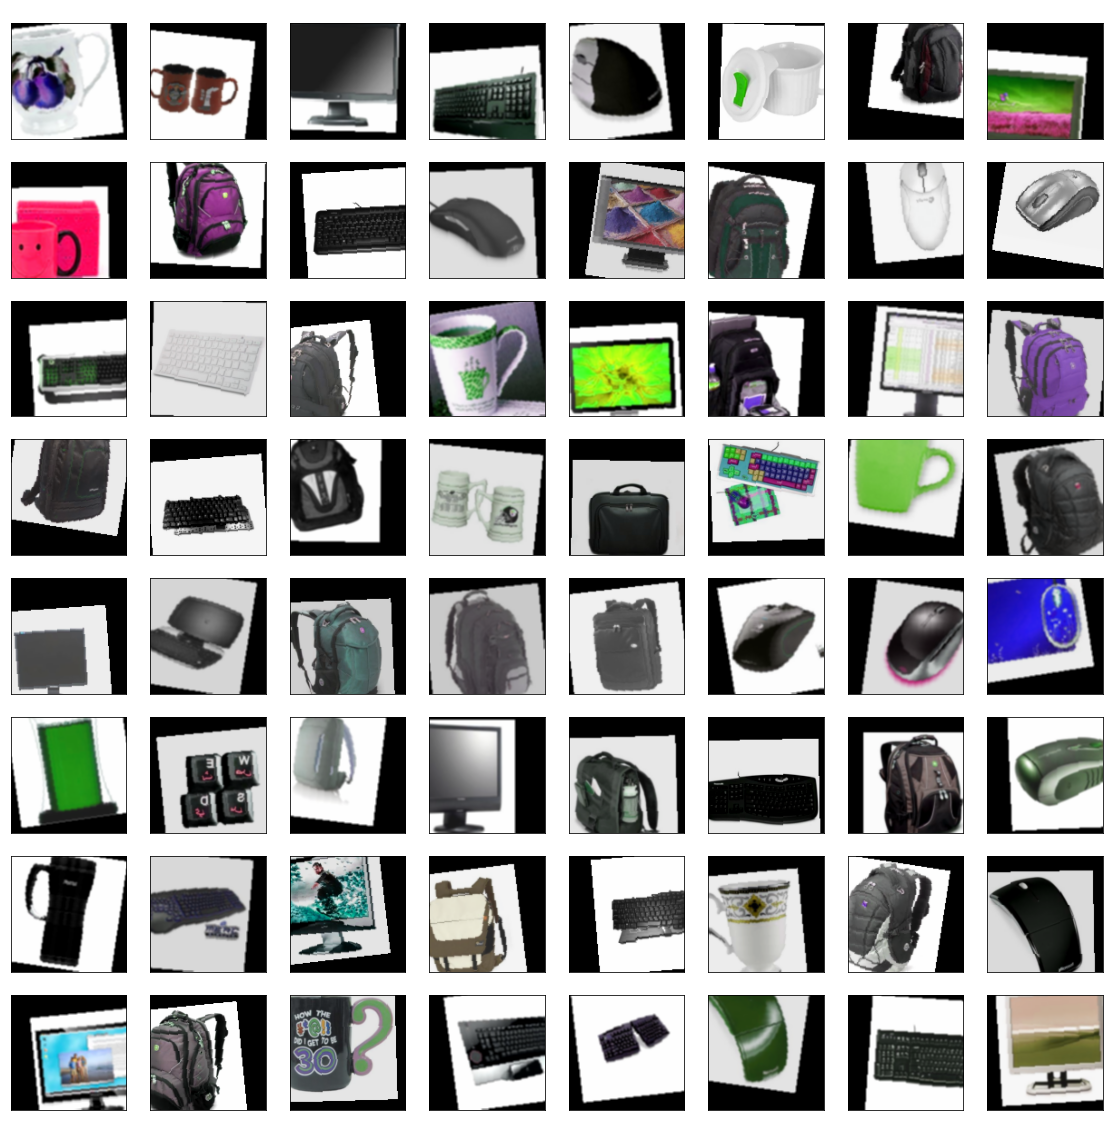

In [8]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset, val_dataset, test_dataset, aug_seed = conf.dataset_fn((conf.data_path, args), load_train=True, load_val=True, load_test=True, validation_split=conf.validation_split, \
                                                           fix_aug=conf.aug_seed, deterministic=conf.deterministic)

train_dataset.visualize_batch()


train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True, worker_init_fn=worker_init_fn)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s\nAugmentation Seed:%s',train_loader.dataset.transform,aug_seed)

#### Set up the device

In [9]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


#### Set up the model

In [10]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Number of Model Params: 287213


#### Set up the optimizer and loss

In [11]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


#### Define the forward function

In [12]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target, path = batch[0].to(conf.device), batch[1].to(conf.device), batch[2]

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

### 1.**Train** the model

In [13]:
train(train_loader, val_loader, model,conf)

Training epoch: 382 samples (32 per mini-batch)
Epoch: [0][   12/   12]    objective_loss 1.597183    Top1 33.870968    LR 0.001000    
--- validate (epoch=0)-----------
42 samples (32 per mini-batch)
Epoch: [0][    2/    2]    Loss 1.523698    Top1 40.476190    
==> Top1: 40.476    Loss: 1.524

==> Confusion:
[[10  1  0  0  0]
 [ 1  3  2  0  0]
 [ 2  1  4  0  0]
 [ 9  1  0  0  0]
 [ 7  1  0  0  0]]

==> Best [Top1: 40.476 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune_office5_SSL300k_base_ev4___2022.07.21-115954/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 382 samples (32 per mini-batch)
Epoch: [1][   12/   12]    objective_loss 1.465539    Top1 40.322581    LR 0.001000    
--- validate (epoch=1)-----------
42 samples (32 per mini-batch)
Epoch: [1][    2/    2]    Loss 1.258502    Top1 45.238095    
==> Top1: 45.238    Loss: 1.259

==> Confusion:
[[10  1  0  0  0]
 [ 1  5  0  0  0]
 [ 3  0  4  0  0]
 [10  0  0  0  0]
 [ 8  0  0  0  0]]

==> Best [Top1: 45.238 

QAT is starting!


Epoch: [8][   12/   12]    objective_loss 0.586371    Top1 75.806452    LR 0.000500    
--- validate (epoch=8)-----------
42 samples (32 per mini-batch)
Epoch: [8][    2/    2]    Loss 0.554345    Top1 76.190476    
==> Top1: 76.190    Loss: 0.554

==> Confusion:
[[10  1  0  0  0]
 [ 0  5  0  1  0]
 [ 0  0  4  1  2]
 [ 2  0  0  5  3]
 [ 0  0  0  0  8]]

==> Best [Top1: 76.190 on epoch: 8]
Saving checkpoint to: jupyter_logging/finetune_office5_SSL300k_base_ev4___2022.07.21-115954/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 382 samples (32 per mini-batch)
Epoch: [9][   12/   12]    objective_loss 0.610840    Top1 80.645161    LR 0.000500    
--- validate (epoch=9)-----------
42 samples (32 per mini-batch)
Epoch: [9][    2/    2]    Loss 0.521766    Top1 78.571429    
==> Top1: 78.571    Loss: 0.522

==> Confusion:
[[10  1  0  0  0]
 [ 0  5  0  1  0]
 [ 0  0  6  0  1]
 [ 2  1  0  4  3]
 [ 0  0  0  0  8]]

==> Best [Top1: 78.571 on epoch: 9]
Saving checkpoint to: jupyter_l

### 2.**Test** the final model on the **source** test set

In [14]:
model = mod.OfficeClassifier()
model_path = "jupyter_logging/finetune_office5_SSL300k_base_ev3___2022.07.21-110137/classifierbackbonenet_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Test: [    2/    2]    Loss 0.267160    Top1 91.666667    
==> Top1: 91.667    Loss: 0.267

==> Confusion:
[[ 9  0  0  0  0]
 [ 0  8  1  1  0]
 [ 0  0  9  0  0]
 [ 1  1  0  8  0]
 [ 0  0  0  0 10]]

==> Test Set [Top1: 91.667   Top5: 100.000  on test set]


### 3.**Test** this model on the **target** test set

In [15]:
# load the train and test sets
_, _, test_dataset, _ = conf.dataset_fn(("../Datasets/domain_adaptation/office5/target/", args), load_train=False, load_val=False,\
                                         load_test=True, validation_split=0, fix_aug=None, deterministic=False)

test_loader = DataLoader(test_dataset, batch_size=32,num_workers=4, pin_memory=True)

model = mod.OfficeClassifier()
model_path = "jupyter_logging/finetune_office5_SSL300k_base_ev3___2022.07.21-110137/classifierbackbonenet_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.


Test: [    2/    2]    Loss 1.121358    Top1 63.492063    
==> Top1: 63.492    Loss: 1.121

==> Confusion:
[[ 6  0  0  1  3]
 [ 0 13  0  5  1]
 [ 0  3  0  5  0]
 [ 0  0  0 12  0]
 [ 0  0  0  5  9]]

==> Test Set [Top1: 63.492   Top5: 100.000  on test set]


### 4.Visualize **Embeddings**  
#### Visualize office clusters from dataset and from camera  
* set the test_batch_path to ../Datasets/domain_adaptation/office5/
* then set the domain to either 0 (source), 1 (target), or 2 (both)
* if you set to source or target, the accuracy over a random batch (from the test set) will be printed and t-sne embeddings will be published for that batch
* if you set to both, no accuracy will be printed but embeddings for both source and target will be published which is useful for visualizing the domain shift

We see that for the source test batch of images we get **91.66%** and for the target test batch of images we get **63.49%**. When visualizing the output embeddings of the CNN encoder we also see that the source images clusters better. However, it is important to note that the target images still cluster but these clusters become *shifted* from the source clusters.


In [16]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/domain_adaptation/office5/",conf,256,"jupyter_logging/finetune_office5_SSL300k_base_ev3___2022.07.21-110137/classifierbackbonenet_qat_best.pth.tar",\
               model,2,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/domain_adaptation/office5//source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5//target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
['monitor_SRC', 'mouse_SRC', 'back_pack_SRC', 'mug_SRC', 'keyboard_SRC', 'mouse_SRC', 'back_pack_SRC', 'mug_SRC', 'monitor_SRC', 'keyboard_SRC', 'keyboard_SRC', 'monitor_SRC', 'mug_SRC', 'monitor_SRC', 'monitor_SRC', 'mouse_SRC', 'back_pack_SRC', 'mouse_SRC', 'monitor_SRC', 'mug_SRC', 'monitor_SRC', 'back_pack_SRC', 'back_pack_SRC', 'keyboard_SRC', 'back_pack_SRC', 'mug_SRC', 'keyboard_SRC', 'back_pack_SRC', 'monitor_SRC', 'back_pack_SRC', 'mouse_SRC', 'mouse_SRC', 'mug_SRC', 'mouse_SRC', 'back_pack_SRC', 'keyboard_SRC', 'mug_SRC', 'mouse_SRC', 'mug_SRC', 'mug_SRC', 'monitor_SRC', 'mug_SRC', 'mouse_SRC', 'keyboard_SRC', 'keyboard_SRC', 'mouse_SRC', 'keyboard_SRC', 'monitor_SRC', 'mug_TGT', 'back_pack_TGT', 

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [2]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best.pth.tar jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best-q.pth.tar --device MAX78000 -v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Configuring device: MAX78000
Converting checkpoint file jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best.pth.tar to jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.

Change virtual environment back to ai8x-training

## **Step 3**: Now let's try to improve the results by including target data

### Let's first try a naive mix of the source and target training data
* the source and target training data are mixed together
* the test data is the source and target test data (evaluate on both)
* repeat this experiment for k = 1,2,4,8

#### 0.**Setup** Training

##### Import the needed modules

In [57]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

##### Configuration for naive mixing

In [175]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "finetune_office5_SSL300k_naive_mix_k8ev3"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/domain_adaptation/office5/source"
        self.deterministic = False
        self.aug_seed = 356096960
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop','mouse','pen')
        self.lr = 0.001
        self.num_epochs = 40
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.final_train = True
        self.start_epoch = 0
        self.k = 8

conf = Config()

##### Logging

In [176]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_office5_SSL300k_naive_mix_k8ev3___2022.07.21-131124/finetune_office5_SSL300k_naive_mix_k8ev3___2022.07.21-131124.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7fb2d2103ee0>
num_classes=5
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=40
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



##### Mixing: Grab k images from the target training set to add into the source training set

In [177]:
# create the target training set
target_train_dataset, _, _, _ = conf.dataset_fn((os.path.dirname(conf.data_path)+"/target", args), load_train=True, load_val=False, load_test=True, validation_split=conf.validation_split, \
                                                           fix_aug=conf.aug_seed, deterministic=conf.deterministic)

# grab an evenly partitioned batch of k per class using the EvenSampler from the target training set
target_batch_size = conf.k*len(target_train_dataset.classes)
target_train_loader = DataLoader(target_train_dataset, batch_size=target_batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=None,sampler=EvenSampler(target_train_dataset,shot=conf.k))

# get the img paths from the loader (these are evenly partiioned by class)
batch = next(iter(target_train_loader))
target_paths = batch[2]
target_labels = batch[1].tolist()

../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


Dataset sizes:
	training=418
	validation=46
	test=48
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)
Augmentation Seed:356096960


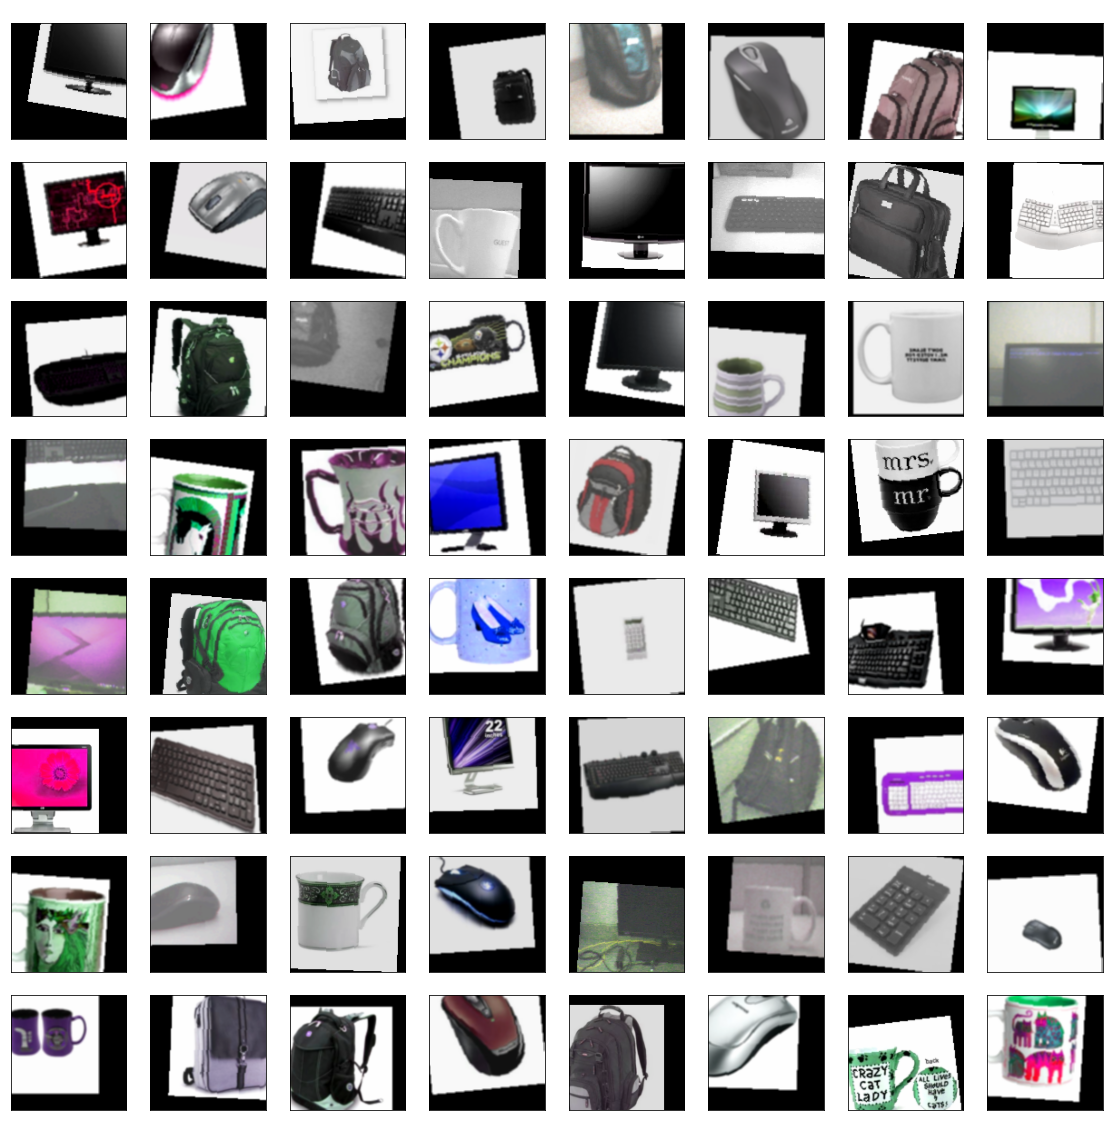

In [178]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

num_val = int(conf.validation_split*target_batch_size)
target_extension = torch.randperm(target_batch_size)

# load the train and test sets
train_dataset, val_dataset, source_test_dataset, aug_seed = conf.dataset_fn((conf.data_path, args), load_train=True, load_val=True, load_test=True, validation_split=conf.validation_split, \
                                                           fix_aug=conf.aug_seed, deterministic=conf.deterministic)
_, _, target_test_dataset, _ = conf.dataset_fn((os.path.dirname(conf.data_path)+"/target", args), load_train=True, load_val=False, load_test=True, validation_split=conf.validation_split, \
                                                           fix_aug=conf.aug_seed, deterministic=conf.deterministic)

# now append the target images to train and val sets and edit the subsets
total_len = len(train_dataset) + len(val_dataset)
train_dataset.imgs.extend(target_paths)
val_dataset.imgs.extend(target_paths)
train_dataset.labels.extend(target_labels)
val_dataset.labels.extend(target_labels)
target_extension += total_len
train_dataset.subset = torch.cat((train_dataset.subset,target_extension[num_val:]))
val_dataset.subset = torch.cat((val_dataset.subset,target_extension[:num_val]))
train_dataset.visualize_batch()


train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)
source_test_loader = DataLoader(source_test_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True, worker_init_fn=worker_init_fn)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(source_test_loader.sampler))
msglogger.info('Augmentations:%s\nAugmentation Seed:%s',train_loader.dataset.transform,aug_seed)

##### Device

In [179]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


##### Model

In [180]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


##### Optimizer, Loss

In [181]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


##### Forward Function

In [182]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

#### 1.**Train** the model

In [183]:
train(train_loader, val_loader, model,conf)

Training epoch: 418 samples (32 per mini-batch)
Epoch: [0][   14/   14]    objective_loss 1.591396    Top1 20.588235    LR 0.001000    
--- validate (epoch=0)-----------
46 samples (32 per mini-batch)
Epoch: [0][    2/    2]    Loss 1.436136    Top1 39.130435    
==> Top1: 39.130    Loss: 1.436

==> Confusion:
[[10  1  0  0  0]
 [ 2  8  0  0  0]
 [ 6  0  0  0  0]
 [ 6  3  0  0  0]
 [10  0  0  0  0]]

==> Best [Top1: 39.130 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune_office5_SSL300k_naive_mix_k8ev3___2022.07.21-131124/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 418 samples (32 per mini-batch)
Epoch: [1][   14/   14]    objective_loss 1.423987    Top1 35.294118    LR 0.001000    
--- validate (epoch=1)-----------
46 samples (32 per mini-batch)
Epoch: [1][    2/    2]    Loss 1.401918    Top1 41.304348    
==> Top1: 41.304    Loss: 1.402

==> Confusion:
[[9 2 0 0 0]
 [1 9 0 0 0]
 [1 5 0 0 0]
 [3 6 0 0 0]
 [5 4 0 0 1]]

==> Best [Top1: 41.304 on epoch: 1]
Savin

QAT is starting!


Epoch: [8][   14/   14]    objective_loss 0.848086    Top1 58.823529    LR 0.000500    
--- validate (epoch=8)-----------
46 samples (32 per mini-batch)
Epoch: [8][    2/    2]    Loss 0.681628    Top1 73.913043    
==> Top1: 73.913    Loss: 0.682

==> Confusion:
[[9 1 0 0 1]
 [0 9 0 1 0]
 [0 1 5 0 0]
 [0 3 1 4 1]
 [2 0 1 0 7]]

==> Best [Top1: 73.913 on epoch: 8]
Saving checkpoint to: jupyter_logging/finetune_office5_SSL300k_naive_mix_k8ev3___2022.07.21-131124/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 418 samples (32 per mini-batch)
Epoch: [9][   14/   14]    objective_loss 0.814053    Top1 61.764706    LR 0.000500    
--- validate (epoch=9)-----------
46 samples (32 per mini-batch)
Epoch: [9][    2/    2]    Loss 0.544966    Top1 80.434783    
==> Top1: 80.435    Loss: 0.545

==> Confusion:
[[11  0  0  0  0]
 [ 0  6  0  4  0]
 [ 0  0  6  0  0]
 [ 0  1  0  6  2]
 [ 1  0  1  0  8]]

==> Best [Top1: 80.435 on epoch: 9]
Saving checkpoint to: jupyter_logging/finetune_of

#### 2.**Test** the final model on the **source** test set

In [188]:
model = mod.OfficeClassifier()
model_path = "jupyter_logging/finetune_office5_SSL300k_naive_mix_k8ev1___2022.07.21-130742/classifierbackbonenet_qat_best.pth.tar"
test(source_test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


Test: [    2/    2]    Loss 0.253523    Top1 93.750000    
==> Top1: 93.750    Loss: 0.254

==> Confusion:
[[ 9  0  0  0  0]
 [ 0  8  1  1  0]
 [ 0  0  9  0  0]
 [ 1  0  0  9  0]
 [ 0  0  0  0 10]]

==> Test Set [Top1: 93.750   Top5: 100.000  on test set]


#### 3.**Test** this model on the **target** test set

In [187]:
# load the train and test sets
_, _, test_dataset, _ = conf.dataset_fn(("../Datasets/domain_adaptation/office5/target/", args), load_train=False, load_val=False,\
                                         load_test=True, validation_split=0, fix_aug=None, deterministic=False)

test_loader = DataLoader(test_dataset, batch_size=32,num_workers=4, pin_memory=True)

model = mod.OfficeClassifier()
model_path = "jupyter_logging/finetune_office5_SSL300k_naive_mix_k8ev1___2022.07.21-130742/classifierbackbonenet_qat_best.pth.tar"
test(test_loader, model, model_path, [pylogger], conf)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.


Test: [    2/    2]    Loss 0.733135    Top1 77.777778    
==> Top1: 77.778    Loss: 0.733

==> Confusion:
[[10  0  0  0  0]
 [ 0 16  0  2  1]
 [ 0  0  6  2  0]
 [ 0  0  3  9  0]
 [ 2  0  0  4  8]]

==> Test Set [Top1: 77.778   Top5: 100.000  on test set]


#### 4.Visualize **Embeddings**  
##### Visualize office clusters from dataset and from camera  
* set the test_batch_path to ../Datasets/domain_adaptation/office5/
* then set the domain to either 0 (source), 1 (target), or 2 (both)
* if you set to source or target, the accuracy over a random batch (from the test set) will be printed and t-sne embeddings will be published for that batch
* if you set to both, no accuracy will be printed but embeddings for both source and target will be published which is useful for visualizing the domain shift

We see that for the source test batch of images we get **91.66%** and for the target test batch of images we get **63.49%**. When visualizing the output embeddings of the CNN encoder we also see that the source images clusters better. However, it is important to note that the target images still cluster but these clusters become *shifted* from the source clusters.

In [56]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/domain_adaptation/office5/",conf,512,"jupyter_logging/finetune_office5_SSL300k_naive_mix_k1ev3___2022.07.21-123425/classifierbackbonenet_qat_best.pth.tar",\
               model,1,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/domain_adaptation/office5//target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
batch acc:  0.6190476190476191


## **Step 4**: Now let's try to do domain adaptation
* repeat this experiment for k = 1,2,4,8

### Validation Selection
Since we have image pairs as samples, selecting a validation set becomes more involved
* **constrained validation**: here we generate many images pairs and then select a subset to be the validation set. The issue here is that while the validation pairs will be unique from the training pairs, individual images can appear in both training and validation since each image can be used to generate multiple pairs. Use constrained validation if 'k' is small for the target (e.g. only one or two images per class).
* **normal validation**: here we split the source and target data into validation sets ahead of time then when generating the validation pairs, we only sample from the source and target validation sets. This way all pairs and images in the validation set are unique from the training set. This however requires a larger 'k' for the target set (at least three).

### First train the discriminator

#### 0.**Setup** Training

##### Reload the modules

In [26]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

##### New Training Parameters for discriminator

In [103]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.log_prefix = "office_dcd_train_SSL300k_k8"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/domain_adaptation/office5/source/"
        self.target_data_path = "../Datasets/domain_adaptation/office5/target/"
        self.deterministic = False
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.0015
        self.num_epochs = 32
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.is_classification = True
        self.start_epoch = 0
        self.constrained_validation = True # for the normal validation the split will be .66-.33
        self.validation_split = 0.1
        self.k = 8

conf = Config()

##### Set up the logger

In [104]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office_dcd_train_SSL300k_k8___2022.07.22-150033/office_dcd_train_SSL300k_k8___2022.07.22-150033.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7fe54e92ed30>
num_classes=4
model_name=officedcdnet
dimensions=(1, 128)
batch_size=32
validation_split=0.1
lr=0.001500
num_epochs=32
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



##### Create and Visualize the dataset
* each sample is a pair of images sampled from G1, G2, G3, G4
* G1 --> same domain, same class
* G2 --> different domain, same class
* G3 --> same domain, different class
* G4 --> different domain, different class
* the first label is the pair label, the parentheses label is the class label

../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568


Dataset sizes:
	training=12212
	validation=1356
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)



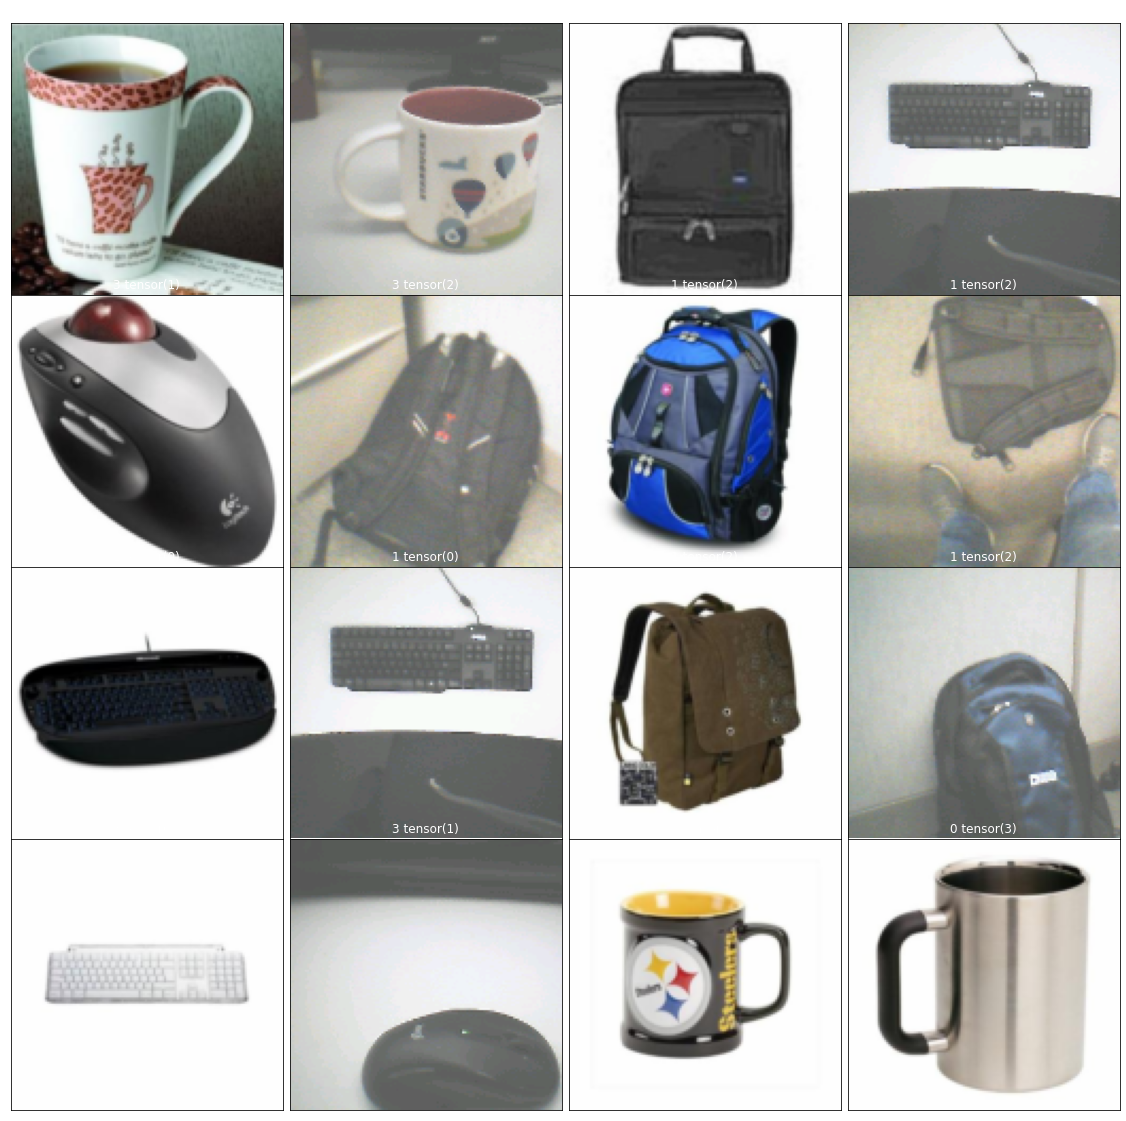

In [105]:
if conf.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset, val_dataset = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), conf,pair_factor=1)

train_dataset.visualize_batch()

train_loader = DataLoader(train_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=conf.batch_size,num_workers=conf.workers, pin_memory=True,worker_init_fn=worker_init_fn)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d', len(train_loader.sampler), len(val_loader.sampler))
msglogger.info('Augmentations:%s\n',train_loader.dataset.transform)

##### Set up the device

In [106]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


##### Set up the model

In [107]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: OfficeDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (do): Dropout(p=0.2, inplace=False)
)
Number of Model Pa

Configuring device: MAX78000, simulate=False.


##### Optimizer, Loss

In [108]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.0015] milestones: Counter({8: 1, 35: 1, 100: 1}) gamma: 0.5


##### Define the forward function

In [109]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/finetune_office5_SSL300k_base_ev1___2022.07.21-105738/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

#### 1.**Train**

In [ ]:
train(train_loader, val_loader, model,conf)

### Now do adversarial training to trick the discriminator

#### 0.**Setup** Training

##### Import modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger
import torch.nn.functional as F

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

##### Training Configuration for both models

In [16]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.log_prefix = "office5_dcd_train_adv_SSL300k_k8ev1"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/domain_adaptation/office5/source/"
        self.target_data_path = "../Datasets/domain_adaptation/office5/target/"
        self.deterministic = False
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':2, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.adv_criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None
        self.constrained_validation = True # for the normal validation the split will be .66-.33
        self.validation_split = 0.1
        self.k = 8
        self.classifier_forward = None

conf_c = Config()
conf_c.lr = 0.001
conf_c.num_classes = 5
conf_c.labels = ('back_pack', 'keyboard','laptop_computer','mouse','pen')
conf_c.model_name = "officeclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 32
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()

In [17]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7f0cc93f7670>
num_classes=5
model_name=officeclassifier
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.1
lr=0.001000
num_epochs=8
qat_policy={'start_epoch': 2, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/domain_adaptation/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  17827  G2 =  3392  G3 =  89676  G4 =  13568
../Datasets/domain_adaptation/office5/source/train
{'keyboard': 0, 'mouse': 

Dataset sizes:
	training=6106
	validation=678
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ToTensor()
)



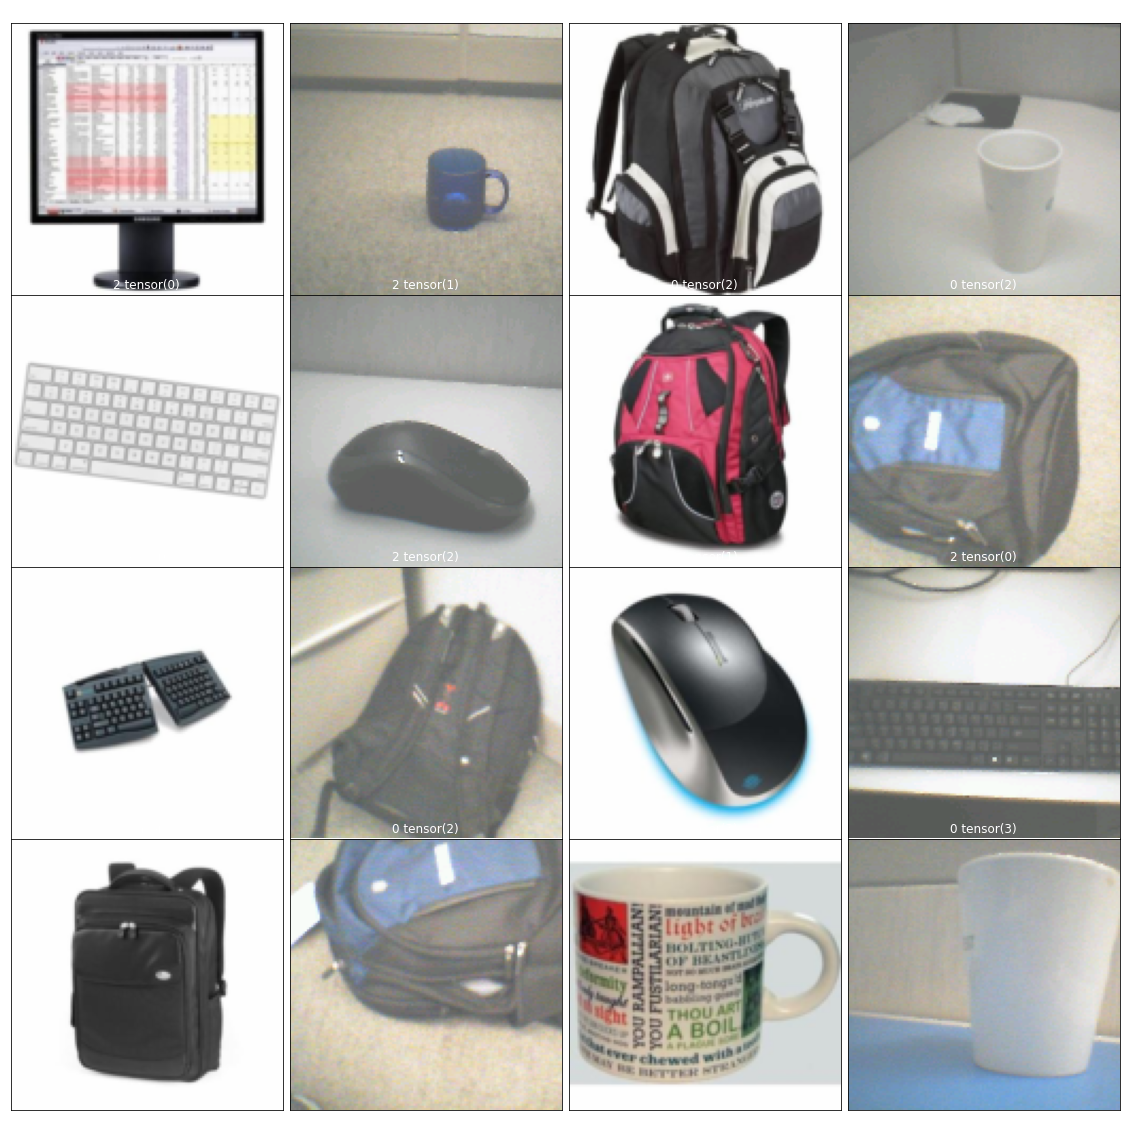

In [18]:
if conf_c.deterministic:
    worker_init_fn = set_deterministic_settings()
else:
    worker_init_fn = None

# load the train and test sets
train_dataset_c, val_dataset_c = conf_c.dataset_fn(((conf_c.source_data_path,conf_c.target_data_path), args), conf_c,pair_factor=1)
train_dataset_d, val_dataset_d = conf_d.dataset_fn(((conf_d.source_data_path,conf_d.target_data_path), args), conf_d,pair_factor=1)

train_dataset_c.visualize_batch()

train_loader_c = DataLoader(train_dataset_c, batch_size=conf_c.batch_size,num_workers=conf_c.workers, pin_memory=True,worker_init_fn=worker_init_fn)
val_loader_c = DataLoader(val_dataset_c, batch_size=conf_c.batch_size,num_workers=conf_c.workers, pin_memory=True,worker_init_fn=worker_init_fn)

train_loader_d= DataLoader(train_dataset_d, batch_size=conf_d.batch_size,num_workers=conf_d.workers, pin_memory=True,worker_init_fn=worker_init_fn)
val_loader_d = DataLoader(val_dataset_d, batch_size=conf_d.batch_size,num_workers=conf_d.workers, pin_memory=True,worker_init_fn=worker_init_fn)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d', len(train_loader_c.sampler), len(val_loader_c.sampler))
msglogger.info('Augmentations:%s\n',train_loader_c.dataset.transform)

In [19]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


In [20]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/finetune_office5_SSL300k_base_ev1___2022.07.21-105738/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/office_dcd_train_SSL300k_k8___2022.07.22-144150/officedcdnet_best.pth.tar"
dcd_model = mod.OfficeDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


In [21]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[2, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[2, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

def dcd_adv_loss(output, target):
    g2s = F.log_softmax(output[target == 0])
    g4s = F.log_softmax(output[target == 2])

    # print("output: ", output)
    # print("target: ", target)

    # print("G2 log-softmax: ", g2s)
    # print("G4 log-softmax: ", g2s)

    term_1 = F.nll_loss(g2s,target[target == 0])
    term_2 = -F.nll_loss(g4s,target[target == 2])

    # print("term 1: ", term_1)
    # print("term 2: ", term_2)
    # () + 1
    
    return term_1 + term_2 

# loss function
#conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
conf_c.adv_criterion = dcd_adv_loss
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({2: 1, 20: 1, 100: 1}) gamma: 0.5


In [22]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat.detach()), target, model(inputs1), imgs1_labels, model(inputs2), imgs2_labels

def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target, path = batch[0].to(conf.device), batch[1].to(conf.device), batch[2]

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_c.classifier_forward = cd_classifier_forward

In [23]:
batch = next(iter(val_loader_d))
out, target = conf_d.forward(dcd_model,batch,conf_d,conf_c)
print(torch.argmax(out,axis=1)-target)

tensor([ 0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
         0,  0,  1, -1,  1,  0, -1, -1,  0, -1,  1,  0,  1, -1],
       device='cuda:0')


In [24]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)
            # print("output: ", dcd_out_c)
            # print("target: ", dcd_target_c)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.adv_criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

In [25]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 1

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.adv_criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                          conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

        # store validation stats
        stats = (
                    'Adv/Validation/',
                    OrderedDict([('Class Loss', class_loss),
                                 ('disc_c Loss', disc_c_loss),
                                 ('disc_d Loss', disc_d_loss),
                                    ('Class Top1', class_top1),
                                    ('disc_c Top1', disc_c_top1),
                                    ('disc_d Top1', disc_d_top1)]),
                                    
                )
        
        if conf_c.num_classes > 5:
            stats[1]['Top5'] = classerr_class.value(5)

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'disc_d_loss': disc_d_loss, 'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('disc_d_loss','epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            msglogger.info('==> Best [disc_d_loss: %.3f on epoch: %d]',
                            score.disc_d_loss, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_disc_d_loss': disc_d_loss,
                            'best_disc_d_loss': perf_scores_history[0].disc_d_loss,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                    scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                    is_best=is_best, name=conf_c.model_name,
                                    dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

In [26]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d)

Training epoch: 6106 samples (32 per mini-batch)


steps in an epoch: 191


Epoch: [0][   31/  191]    class_loss 0.807008    disc_c_loss 0.457202    class Top1 88.476562    disc_c Top1 42.187500    LR 0.001000    
Epoch: [0][   32/  191]    disc_d_loss 1.159703    disc_d Top1 55.078125    LR 0.001000    
Epoch: [0][   63/  191]    class_loss 0.514335    disc_c_loss 0.369749    class Top1 93.603516    disc_c Top1 49.902344    LR 0.001000    
Epoch: [0][   64/  191]    disc_d_loss 1.029749    disc_d Top1 58.203125    LR 0.001000    
--- validate (epoch=0)-----------
678 samples (32 per mini-batch)
Epoch: [0][   22/   22]    Class Loss 0.978026    disc_c Loss 0.111157    disc_d Loss 1.345809    Class Top1 84.375000    disc_c Top1 43.750000    disc_d Top1 50.000000    
Epoch: [0][   32/   22]    Class Loss 0.978026    disc_c Loss 0.111157    disc_d Loss 1.345809    Class Top1 84.375000    disc_c Top1 43.750000    disc_d Top1 50.000000    
==> Class Top1: 84.375    Class Loss: 0.978    DCD_c Top1: 43.750 DCD_c Loss: 0.111    DCD_d Top1: 50.000 DCD_d Loss: 1.346

=

steps in an epoch: 191


Epoch: [1][   31/  191]    class_loss 0.118331    disc_c_loss 0.332322    class Top1 99.804688    disc_c Top1 63.281250    LR 0.001000    
Epoch: [1][   32/  191]    disc_d_loss 0.652049    disc_d Top1 68.359375    LR 0.001000    
Epoch: [1][   63/  191]    class_loss 0.098454    disc_c_loss 0.353488    class Top1 99.902344    disc_c Top1 62.109375    LR 0.001000    
Epoch: [1][   64/  191]    disc_d_loss 0.615857    disc_d Top1 70.117188    LR 0.001000    
--- validate (epoch=1)-----------
678 samples (32 per mini-batch)
Epoch: [1][   22/   22]    Class Loss 0.834774    disc_c Loss 0.419170    disc_d Loss 1.614322    Class Top1 87.500000    disc_c Top1 25.000000    disc_d Top1 43.750000    
Epoch: [1][   32/   22]    Class Loss 0.834774    disc_c Loss 0.419170    disc_d Loss 1.614322    Class Top1 87.500000    disc_c Top1 25.000000    disc_d Top1 43.750000    
==> Class Top1: 87.500    Class Loss: 0.835    DCD_c Top1: 25.000 DCD_c Loss: 0.419    DCD_d Top1: 43.750 DCD_d Loss: 1.614

=

QAT is starting!
steps in an epoch: 191


Epoch: [2][   31/  191]    class_loss 0.055862    disc_c_loss 0.206117    class Top1 100.000000    disc_c Top1 54.882812    LR 0.000500    
Epoch: [2][   32/  191]    disc_d_loss 0.944714    disc_d Top1 74.414062    LR 0.000500    
Epoch: [2][   63/  191]    class_loss 0.054948    disc_c_loss 0.234089    class Top1 100.000000    disc_c Top1 59.375000    LR 0.000500    
Epoch: [2][   64/  191]    disc_d_loss 0.928206    disc_d Top1 75.781250    LR 0.000500    
--- validate (epoch=2)-----------
678 samples (32 per mini-batch)
Epoch: [2][   22/   22]    Class Loss 0.874102    disc_c Loss 0.278779    disc_d Loss 1.286016    Class Top1 89.062500    disc_c Top1 46.875000    disc_d Top1 43.750000    
Epoch: [2][   32/   22]    Class Loss 0.874102    disc_c Loss 0.278779    disc_d Loss 1.286016    Class Top1 89.062500    disc_c Top1 46.875000    disc_d Top1 43.750000    
==> Class Top1: 89.062    Class Loss: 0.874    DCD_c Top1: 46.875 DCD_c Loss: 0.279    DCD_d Top1: 43.750 DCD_d Loss: 1.286


steps in an epoch: 191


Epoch: [3][   31/  191]    class_loss 0.045366    disc_c_loss 0.344648    class Top1 100.000000    disc_c Top1 61.914062    LR 0.000500    
Epoch: [3][   32/  191]    disc_d_loss 0.878232    disc_d Top1 77.343750    LR 0.000500    
Epoch: [3][   63/  191]    class_loss 0.043746    disc_c_loss 0.388634    class Top1 100.000000    disc_c Top1 57.421875    LR 0.000500    
Epoch: [3][   64/  191]    disc_d_loss 0.869665    disc_d Top1 77.441406    LR 0.000500    
--- validate (epoch=3)-----------
678 samples (32 per mini-batch)
Epoch: [3][   22/   22]    Class Loss 0.911218    disc_c Loss 0.337607    disc_d Loss 1.298002    Class Top1 89.062500    disc_c Top1 37.500000    disc_d Top1 34.375000    
Epoch: [3][   32/   22]    Class Loss 0.911218    disc_c Loss 0.337607    disc_d Loss 1.298002    Class Top1 89.062500    disc_c Top1 37.500000    disc_d Top1 34.375000    
==> Class Top1: 89.062    Class Loss: 0.911    DCD_c Top1: 37.500 DCD_c Loss: 0.338    DCD_d Top1: 34.375 DCD_d Loss: 1.298


steps in an epoch: 191


Epoch: [4][   31/  191]    class_loss 0.038206    disc_c_loss 0.468071    class Top1 100.000000    disc_c Top1 50.000000    LR 0.000500    
Epoch: [4][   32/  191]    disc_d_loss 0.844024    disc_d Top1 77.539062    LR 0.000500    
Epoch: [4][   63/  191]    class_loss 0.037351    disc_c_loss 0.499051    class Top1 100.000000    disc_c Top1 49.121094    LR 0.000500    
Epoch: [4][   64/  191]    disc_d_loss 0.832741    disc_d Top1 78.613281    LR 0.000500    
--- validate (epoch=4)-----------
678 samples (32 per mini-batch)
Epoch: [4][   22/   22]    Class Loss 0.885575    disc_c Loss 0.413614    disc_d Loss 1.316553    Class Top1 87.500000    disc_c Top1 31.250000    disc_d Top1 34.375000    
Epoch: [4][   32/   22]    Class Loss 0.885575    disc_c Loss 0.413614    disc_d Loss 1.316553    Class Top1 87.500000    disc_c Top1 31.250000    disc_d Top1 34.375000    
==> Class Top1: 87.500    Class Loss: 0.886    DCD_c Top1: 31.250 DCD_c Loss: 0.414    DCD_d Top1: 34.375 DCD_d Loss: 1.317


steps in an epoch: 191


Epoch: [5][   31/  191]    class_loss 0.030726    disc_c_loss 0.577856    class Top1 100.000000    disc_c Top1 47.070312    LR 0.000500    
Epoch: [5][   32/  191]    disc_d_loss 0.806227    disc_d Top1 81.445312    LR 0.000500    
Epoch: [5][   63/  191]    class_loss 0.030016    disc_c_loss 0.593434    class Top1 100.000000    disc_c Top1 46.777344    LR 0.000500    
Epoch: [5][   64/  191]    disc_d_loss 0.800036    disc_d Top1 80.664062    LR 0.000500    
--- validate (epoch=5)-----------
678 samples (32 per mini-batch)
Epoch: [5][   22/   22]    Class Loss 0.923752    disc_c Loss 0.426561    disc_d Loss 1.334095    Class Top1 89.062500    disc_c Top1 18.750000    disc_d Top1 34.375000    
Epoch: [5][   32/   22]    Class Loss 0.923752    disc_c Loss 0.426561    disc_d Loss 1.334095    Class Top1 89.062500    disc_c Top1 18.750000    disc_d Top1 34.375000    
==> Class Top1: 89.062    Class Loss: 0.924    DCD_c Top1: 18.750 DCD_c Loss: 0.427    DCD_d Top1: 34.375 DCD_d Loss: 1.334


steps in an epoch: 191


Epoch: [6][   31/  191]    class_loss 0.027643    disc_c_loss 0.645771    class Top1 100.000000    disc_c Top1 42.382812    LR 0.000500    
Epoch: [6][   32/  191]    disc_d_loss 0.776861    disc_d Top1 80.664062    LR 0.000500    
Epoch: [6][   63/  191]    class_loss 0.027782    disc_c_loss 0.669116    class Top1 100.000000    disc_c Top1 41.308594    LR 0.000500    
Epoch: [6][   64/  191]    disc_d_loss 0.773081    disc_d Top1 80.761719    LR 0.000500    
--- validate (epoch=6)-----------
678 samples (32 per mini-batch)
Epoch: [6][   22/   22]    Class Loss 0.943301    disc_c Loss 0.506303    disc_d Loss 1.354327    Class Top1 87.500000    disc_c Top1 15.625000    disc_d Top1 31.250000    
Epoch: [6][   32/   22]    Class Loss 0.943301    disc_c Loss 0.506303    disc_d Loss 1.354327    Class Top1 87.500000    disc_c Top1 15.625000    disc_d Top1 31.250000    
==> Class Top1: 87.500    Class Loss: 0.943    DCD_c Top1: 15.625 DCD_c Loss: 0.506    DCD_d Top1: 31.250 DCD_d Loss: 1.354


steps in an epoch: 191


Epoch: [7][   31/  191]    class_loss 0.026198    disc_c_loss 0.728511    class Top1 100.000000    disc_c Top1 41.015625    LR 0.000500    
Epoch: [7][   32/  191]    disc_d_loss 0.750696    disc_d Top1 81.250000    LR 0.000500    
Traceback (most recent call last):
Epoch: [7][   63/  191]    class_loss 0.024136    disc_c_loss 0.757595    class Top1 100.000000    disc_c Top1 40.136719    LR 0.000500    
Epoch: [7][   64/  191]    disc_d_loss 0.745631    disc_d Top1 81.835938    LR 0.000500    
--- validate (epoch=7)-----------
678 samples (32 per mini-batch)
Epoch: [7][   22/   22]    Class Loss 0.910633    disc_c Loss 0.550538    disc_d Loss 1.381237    Class Top1 89.062500    disc_c Top1 18.750000    disc_d Top1 31.250000    
Epoch: [7][   32/   22]    Class Loss 0.910633    disc_c Loss 0.550538    disc_d Loss 1.381237    Class Top1 89.062500    disc_c Top1 18.750000    disc_d Top1 31.250000    
==> Class Top1: 89.062    Class Loss: 0.911    DCD_c Top1: 18.750 DCD_c Loss: 0.551    DC

#### Test

In [28]:
conf_c.forward = classifier_forward

# load the train and test sets
_, _, test_dataset, _ = office5_get_datasets((conf_c.target_data_path, args), load_train=False, load_val=False, load_test=True, validation_split=0, \
                                                           fix_aug=None, deterministic=False)

test_loader = DataLoader(test_dataset, batch_size=32,num_workers=4, pin_memory=True)

model = mod.OfficeClassifier()
model_path = "jupyter_logging/office5_dcd_train_adv_SSL300k_k8ev1___2022.07.22-153455/officeclassifier_qat_checkpoint.pth.tar"
test(test_loader, model, model_path, [pylogger], conf_c)

=> loading checkpoint jupyter_logging/SSL___2022.07.15-171757/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/domain_adaptation/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.


Test: [    2/    2]    Loss 0.619137    Top1 87.301587    
==> Top1: 87.302    Loss: 0.619

==> Confusion:
[[10  0  0  0  0]
 [ 0 18  0  0  1]
 [ 0  1  6  0  1]
 [ 0  0  2 10  0]
 [ 0  1  0  2 11]]

==> Test Set [Top1: 87.302   Top5: 100.000  on test set]


## Visualize embeddings again

In [10]:
def adv_viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False,dataset_fn=None):
    if dataset_fn != None:
        _, test_set = dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    else:
        _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc2.register_forward_hook(get_activation('fc2'))
    preds = model(batch_imgs)
    embds = activation['fc2']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [11]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-143253/officeclassifier_qat_checkpoint.pth.tar",model,True,office5_get_datasets)
adv_viz_embeddings("../Datasets/office5_both/",conf_c,256,"jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5_both/test
{'back_pack_camera': 0, 'mouse_dataset': 1, 'keyboard_dataset': 2, 'monitor_dataset': 3, 'mug_dataset': 4, 'back_pack_dataset': 5, 'keyboard_camera': 6, 'monitor_camera': 7, 'mug_camera': 8, 'mouse_camera': 9}
Configuring device: MAX78000, simulate=False.
batch acc:  0.04090909090909091
